In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotly 
import plotly.plotly as py

In [3]:
plotly.tools.set_credentials_file(username='falrashidi', api_key='XaO64TRYU0N3Sdup8Z3H')

In [4]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

### Plotly & Cufflinks
At this point you will need to isntall `cufflinks`. `Cufflinks` binds `Plotly` directly to pandas dataframes.
```python
! pip install cufflinks --upgrade
```

In [5]:
import cufflinks as cf
print(cf.__version__)
import pandas as pd
import numpy as np
import gzip

# Configure cufflings 
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

0.12.1


## Loading the Data
The below functions are provided directly from the [Amazon Review Data link](http://jmcauley.ucsd.edu/data/amazon/) by the author and it is used to load the [5-cores](https://en.wikipedia.org/wiki/Degeneracy_(graph_theory)) book reviews as a `panda dataframe`.

In [6]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

In [7]:
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [8]:
df = getDF('/Users/falehalrashidi/Downloads/reviews_Books_5.json.gz')

I used the below snippet to monitor the memory requirements for the loading. 

In [9]:
%load_ext memory_profiler
%memit

peak memory: 15529.86 MiB, increment: 0.20 MiB


Below you can see the fields loaded and a count of the values per field;

In [10]:
df.count()

reviewerID        8898041
asin              8898041
reviewerName      8872495
helpful           8898041
reviewText        8898041
overall           8898041
summary           8898041
unixReviewTime    8898041
reviewTime        8898041
dtype: int64

A sample of the overal data appears next:

In [11]:
df[0:10]

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A10000012B7CGYKOMPQ4L,000100039X,Adam,"[0, 0]",Spiritually and mentally inspiring! A book tha...,5.0,Wonderful!,1355616000,"12 16, 2012"
1,A2S166WSCFIFP5,000100039X,"adead_poet@hotmail.com ""adead_poet@hotmail.com""","[0, 2]",This is one my must have books. It is a master...,5.0,close to god,1071100800,"12 11, 2003"
2,A1BM81XB4QHOA3,000100039X,"Ahoro Blethends ""Seriously""","[0, 0]",This book provides a reflection that you can a...,5.0,Must Read for Life Afficianados,1390003200,"01 18, 2014"
3,A1MOSTXNIO5MPJ,000100039X,Alan Krug,"[0, 0]",I first read THE PROPHET in college back in th...,5.0,Timeless for every good and bad time in your l...,1317081600,"09 27, 2011"
4,A2XQ5LZHTD4AFT,000100039X,Alaturka,"[7, 9]",A timeless classic. It is a very demanding an...,5.0,A Modern Rumi,1033948800,"10 7, 2002"
5,A3V1MKC2BVWY48,000100039X,Alex Dawson,"[0, 0]",Reading this made my mind feel like a still po...,5.0,This book will bring you peace,1390780800,"01 27, 2014"
6,A12387207U8U24,000100039X,Alex,"[0, 0]","As you read, Gibran's poetry brings spiritual ...",5.0,Graet Work,1206662400,"03 28, 2008"
7,A29TRDMK51GKZR,000100039X,Alpine Plume,"[0, 0]","Deep, moving dramatic verses of the heart and ...",5.0,Such Beauty,1383436800,"11 3, 2013"
8,A3FI0744PG1WYG,000100039X,"Always Reading ""tkm""","[0, 0]",This is a timeless classic. Over the years I'...,5.0,The Prophet,1390953600,"01 29, 2014"
9,A2LBBQHYLEHM7P,000100039X,"Amazon Customer ""Full Frontal Nerdity""","[0, 0]",An amazing work. Realizing extensive use of Bi...,5.0,A Modern Classic,1379808000,"09 22, 2013"


## Column Fields of Interest
In general, the loaded dataframe, include 7 fields:
* `reviewerID: A `String` (probably a hashText) that uniquely identifies the user that submitted the review.     
* `asin`: ASIN stands for **Amazon Standard Identification Number**. Almost every product on **Amazon** has its own **ASIN**, a unique code used to identify it. For books, the **ASIN** is the same as the book's **ISBN** number.       
* `reviewerName`: The name of the reviewer.       
* `helpful`: Amazon has implemented an interface that allows customers to vote on whether a particular review
has been helpful or unhelpful. This is captured by this field, which represents a rating of the review, e.g. if `[2,3] --> 2/3`. 
* `reviewText`: The actual review provided by the reviewer.         
* `overall`: The product's rating attributed by the same reviewer.            
* `summary`: A summary of the review.        
* `unixReviewTime`:  Time of the review (unix time).
* `reviewTime`: Time of the review (raw).

Of these fields, for the purposes of this project we care to keep the `reviewerID`, `asin`, `reviewText`, `overall` and `helpful`. Specifically, we keep `reviewerID` only to merge it with `asin` and create unique identifier (`key`) per review, e.g.:

```python
key = reviewerID:"A10000012B7CGYKOMPQ4L" + asin:"000100039X"
```

`asin` is obviously necessary to identify the distinct books in the dataset, while the rest are necessary for the analysis (`overall`, `reviewText`) and for evaluation (`helpful`) purposes.

 ## Data Inspection

In [12]:
# Number of reviews:
number_of_reviews=len(df)
my_number_string = '{:0,.0f}'.format(number_of_reviews)

print('Number of Reviews: ' + my_number_string + '.')

Number of Reviews: 8,898,041.


In [13]:
# Unique number of items:
unique_books=len(df['asin'].unique())
my_number_string = '{:0,.0f}'.format(unique_books)

print('Number of Books: ' + my_number_string + '.')

Number of Books: 367,982.


### Distribution of ratings amongst all reviews

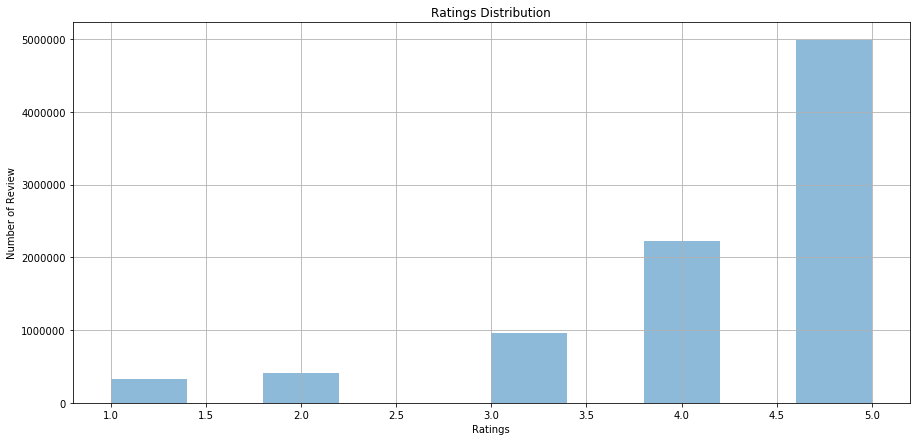

In [14]:
# Distribution of Ratings (too many to plot with plotly)
fig = df['overall'].plot.hist(alpha=0.5, title='Ratings Distribution', figsize=(15,7), grid=True)
fig.set_xlabel("Ratings")
fig.set_ylabel("Number of Review")

In [15]:
df10 = df[['overall','asin']]

In [16]:
df11 = pd.DataFrame(df10.groupby(['asin'])['overall'].mean())

### Distribution of Average Book Ratings

In [17]:
len(df11)

367982

In [18]:
df11 = df11.reset_index()
df11.head()

,asin,overall
0,000100039X,4.674757
1,0001055178,3.555556
2,0001473123,4.625000
3,0001473727,5.000000
4,0001473905,4.666667


In [19]:
df11['overall'].iplot(kind='histogram', bins=100, xTitle='Rating (0-5)',yTitle='Number of Books', title='Average Book Ratings')
# df11.plot.hist(alpha=0.5,bins=100)

### Books per Year

In [20]:
df20 = df[['asin','reviewTime']]

In [21]:
def get_year(reviewTime):
    day_month_year_list = reviewTime.split(',')
    
    if(len(day_month_year_list)==2): 
        return day_month_year_list[1]
    else:
        return fillna(0)

In [22]:
df20['reviewYear'] = pd.DataFrame(df20['reviewTime'].apply(lambda time: get_year(time)))

In [23]:
df20.head()

,asin,reviewTime,reviewYear
0,000100039X,"12 16, 2012",2012
1,000100039X,"12 11, 2003",2003
2,000100039X,"01 18, 2014",2014
3,000100039X,"09 27, 2011",2011
4,000100039X,"10 7, 2002",2002


In [24]:
books_per_year = pd.DataFrame(df20.groupby(['reviewYear']).size())

In [25]:
books_per_year.columns = ['counts']

In [26]:
books_per_year.iplot(kind='bar', xTitle='Years', yTitle='Number of Books', title='Number of Books per Year')

In [27]:
df30 = df[['asin','reviewTime', 'overall']]

In [28]:
df30['reviewYear'] = pd.DataFrame(df30['reviewTime'].apply(lambda time: get_year(time)))

In [29]:
df30.head()

,asin,reviewTime,overall,reviewYear
0,000100039X,"12 16, 2012",5.0,2012
1,000100039X,"12 11, 2003",5.0,2003
2,000100039X,"01 18, 2014",5.0,2014
3,000100039X,"09 27, 2011",5.0,2011
4,000100039X,"10 7, 2002",5.0,2002


In [30]:
books_per_rating_per_year = df30.groupby(['reviewYear','overall']).size().reset_index(name='counts')

In [31]:
books_per_rating_per_year[0:10]

,reviewYear,overall,counts
0,1996,1.0,1
1,1996,2.0,2
2,1996,3.0,1
3,1996,4.0,6
4,1996,5.0,15
5,1997,1.0,80
6,1997,2.0,132
7,1997,3.0,174
8,1997,4.0,466
9,1997,5.0,1189


In [32]:
pivot_df = books_per_rating_per_year.pivot(index='reviewYear', columns='overall', values='counts')

In [33]:
pivot_df.iplot(kind='bar', barmode='stack', xTitle='Years', yTitle='Number of Books', title='Number of Books per Rating per Year')

### Helpfulness

In [34]:
df40 = df[['asin', 'helpful']]

In [35]:
# Create new Column for the enumerator
df40 = df40.assign(enum = df40['helpful'].apply(lambda enum_denom:enum_denom[0]))

In [36]:
# Create new Column for the denominator
df40 = df40.assign(denom = df40['helpful'].apply(lambda enum_denom:enum_denom[1]))

In [37]:
# Filter on the denom
df40 = df40.loc[df40['denom'] != 0]

In [38]:
df40[0:15]

,asin,helpful,enum,denom
1,000100039X,"[0, 2]",0,2
4,000100039X,"[7, 9]",7,9
14,000100039X,"[1, 1]",1,1
15,000100039X,"[1, 1]",1,1
17,000100039X,"[3, 5]",3,5
18,000100039X,"[1, 1]",1,1
19,000100039X,"[3, 3]",3,3
21,000100039X,"[2, 3]",2,3
22,000100039X,"[1, 4]",1,4
23,000100039X,"[2, 9]",2,9


In [39]:
len(df40)

4756837

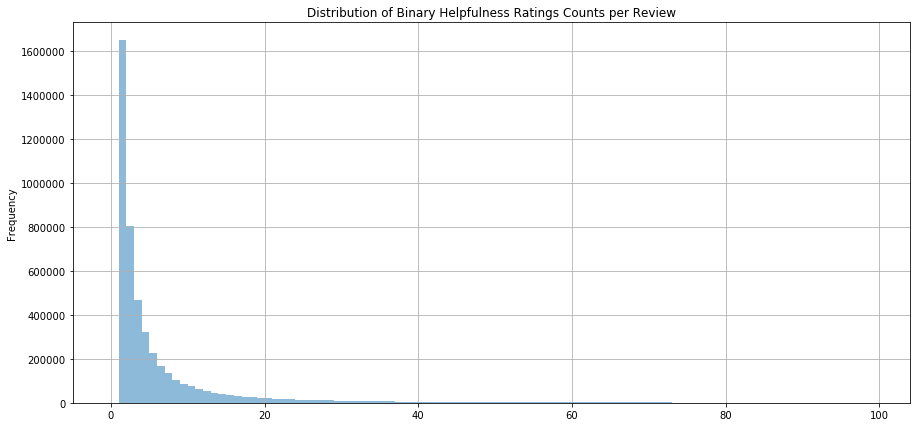

In [40]:
bin_values = np.arange(start=0,stop=100,step=1)
df40['denom'].plot.hist(alpha=0.5, bins=bin_values, figsize=(15,7), grid=True, title='Distribution of Binary Helpfulness Ratings Counts per Review')

In [41]:
# Focus on [10,100] range of rating per review
df40 = df40.loc[df40['denom'] > 15]
df40 = df40.loc[df40['denom'] < 100]
len(df40)

439769

In [42]:
df50 = df40.assign(percentage = df40['enum']/df40['denom'])
df50['percentage'].iplot(kind='histogram', title='Distribution of Helpfulness Percentage')

In [43]:
df50.head()

,asin,helpful,enum,denom,percentage
34,000100039X,"[81, 92]",81,92,0.880435
106,000100039X,"[17, 20]",17,20,0.850000
121,000100039X,"[0, 56]",0,56,0.000000
123,000100039X,"[10, 28]",10,28,0.357143
133,000100039X,"[19, 25]",19,25,0.760000


In [44]:
threshold = 0.7
df60 = df50.loc[df50['percentage'] > threshold]

In [45]:
len(df60)

295941

In [46]:
# END OF FILE